## Imports

In [1]:
import pandas as pd
import numpy as np
import open3d as o3d
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from sklearn.metrics import precision_recall_curve
from numpy import argmax

In [43]:
STATISTICS = ["median", "std", "max", "min"]
CELL_SIZE = 0.5 # 0.5 meters
Z_INDEX = 3

## Read the data

In [5]:
# Read data
data = pd.read_csv("data/felt2_points.csv")
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]

In [4]:
data.head(10)

,accepted,x,y,z,thu,tvu
0,1.0,0.00,7.90,39.91,0.09,0.12
1,1.0,0.00,7.97,39.88,0.21,0.19
2,1.0,0.05,8.39,39.93,0.23,0.21
3,1.0,0.06,8.71,39.78,0.09,0.12
4,1.0,0.07,9.11,40.04,0.15,0.12
5,1.0,0.07,9.40,40.05,0.15,0.12
6,1.0,0.08,7.97,39.83,0.15,0.12
7,1.0,0.08,8.01,39.82,0.16,0.13
8,1.0,0.08,8.26,39.82,0.15,0.12
9,1.0,0.08,8.35,39.67,0.21,0.19


## Select area

In [6]:
def area_of_dataframe(dataframe, x_start, x_last, y_start, y_last):
    area_dataframe = dataframe[
        (dataframe["x"] >= x_start) &
        (dataframe["x"] < x_last) & 
        (dataframe["y"] >= y_start) & 
        (dataframe["y"] < y_last)
    ]
    return area_dataframe

In [48]:
# Pick an area
xStart = np.min(data.x)+20 # Start meter x
yStart = np.min(data.y)+0 # Start meter y
area = 20
data_area = area_of_dataframe(data, xStart, xStart+area, yStart, yStart+area)
len(data_area)

43851

In [22]:
len(data_area[data_area.accepted == 0]) / len(data_area[data_area.accepted == 1])

0.1334505137912385

## Visualize

In [11]:
def visualize_area(data_area, voxel_size=0.02):
    _x = np.array(data_area.x)
    _y = np.array(data_area.y)
    _z = np.array(data_area.z)

    _red = np.array(np.zeros(len(data_area.x)))
    _green = np.array(np.zeros(len(data_area.x)))
    _blue = np.array(np.zeros(len(data_area.x)))

    acceptance = np.array(data_area.accepted)
    for idx, val in enumerate(acceptance):
        
        if val > 0:
            _green[idx] = 65535
        else:
            _red[idx] = 65535

    pcd = o3d.geometry.PointCloud()

    pcd.points = o3d.utility.Vector3dVector(np.vstack((_x, _y, _z)).transpose())
    pcd.colors = o3d.utility.Vector3dVector(np.vstack((_red, _green, _blue)).transpose()/65535)

    voxel_grid=o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=voxel_size)

    o3d.visualization.draw_geometries([voxel_grid])

In [23]:
visualize_area(data_area)

## Dataframe to normalized cells

In [24]:
def cell_statistics(cell, z_index):
    cell_z = cell[:, z_index]
    median = np.median(cell_z)
    std = np.std(cell_z)
    mx = np.max(cell_z)
    mn = np.min(cell_z)

    return median, std, mx, mn

In [25]:
def dataframe_to_normalized_stats_cells(dataframe, cells_in_x, cells_in_y, MinMaxArea, z_index):
    cells = []
    visualize_cell = []

    sample_min = np.min(MinMaxArea, axis=0)
    sample_max = np.max(MinMaxArea, axis=0)

    for ix, x in enumerate(cells_in_x):
        for iy, y in enumerate(cells_in_y):
            if ix != 0 and iy != 0:
                cell = np.array(area_of_dataframe(dataframe, cells_in_x[ix-1], x, cells_in_y[iy-1], y)) 
                visualize_cell.append(cell)            

                if len(cell) <= 0:
                    cells.append(cell)
                else:
                    # Normalize
                    norm_cell = (cell - sample_min) / (sample_max - sample_min)
                    
                    # Add cell statistics
                    median, std, mx, mn = cell_statistics(norm_cell, z_index)
                    stats = np.array([[median, std, mx, mn] for i in range(len(norm_cell))])
                    norm_cell_stats = np.append(norm_cell, stats, axis=1)

                    cells.append(norm_cell_stats)
    
    return cells, visualize_cell

In [49]:
# Turn area into cells
cells_in_x = np.arange(data_area.x.min(), data_area.x.max()+CELL_SIZE, CELL_SIZE)
cells_in_y = np.arange(data_area.y.min(), data_area.y.max()+CELL_SIZE, CELL_SIZE)
cells, visualize_cells = dataframe_to_normalized_stats_cells(data_area, cells_in_x, cells_in_y, np.array(data), Z_INDEX)

## Find cell neighbors

In [27]:
def check_neighbor(all_stats, current_cell, len_stats):
    if len(current_cell) <= 0:
        return np.concatenate((all_stats, np.array([-1 for i in range(len_stats)])), axis=0)
    else:
        return np.concatenate((all_stats, current_cell[0, -len_stats:]), axis=0)

In [28]:
def get_cell_neighbors(cells, cells_in_y, num_neighbors, len_stats, visualize_cells):
    num_cells_in_y = len(cells_in_y)-1
    neighbor_cells = []
    neighor_visualize_cells = []

    for cell_idx in range(len(cells)):
        if len(cells[cell_idx]) <= 0:
            continue

        if cell_idx < num_cells_in_y*num_neighbors or cell_idx >= len(cells)-num_cells_in_y*num_neighbors:
            continue # Continue on horizontal edges
        if (cell_idx % num_cells_in_y) < num_neighbors or (cell_idx % num_cells_in_y) >= num_cells_in_y-num_neighbors:
            continue # Continue on vertical edges

        all_neighbor_stats = np.array([])
        for nx in range(1, num_neighbors+1):
            all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx-(num_cells_in_y*nx))], len_stats) # Neighbors to the left
            all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx-nx)], len_stats) # Neighbors above
            all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx+nx)], len_stats) # Neighbors below
            all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx+(num_cells_in_y*nx))], len_stats) # Neighbors to the right
            for ny in range(1, num_neighbors+1):
                all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx-((num_cells_in_y*nx)+ny))], len_stats) # Left corners
                all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx-((num_cells_in_y*nx)-ny))], len_stats) # Left corners
                all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx+((num_cells_in_y*nx)-ny))], len_stats) # Right corners
                all_neighbor_stats = check_neighbor(all_neighbor_stats, cells[(cell_idx+((num_cells_in_y*nx)+ny))], len_stats) # Right corners

        # Add stats to current cell
        stats = np.array([all_neighbor_stats for i in range(len(cells[cell_idx]))]) # np.concatenate instead?
        neighbor_cell_stats = np.append(cells[cell_idx], stats, axis=1)
        neighbor_cells.append(neighbor_cell_stats)
        neighor_visualize_cells.append(visualize_cells[cell_idx])

    return neighbor_cells, neighor_visualize_cells

In [50]:
# Get neighbor cells for each cell
num_neighbors = 4
neighbors, neighbors_visualize = get_cell_neighbors(cells, cells_in_y, num_neighbors, len(STATISTICS), visualize_cells)
processed_data = np.concatenate(neighbors)
processed_data_visualize = np.concatenate(neighbors_visualize)

In [51]:
processed_data.shape

(26609, 330)

In [52]:
X_test = processed_data[:, Z_INDEX:]
y_test = processed_data[:, 0]
X_visualize = processed_data_visualize[:, 1:4]
y_visualize = processed_data_visualize[:, 0]

## Load and test models

In [33]:
def evaluate(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return confusion, f1, accuracy, recall

def evaluate_testing(y_test, y_pred):
    confusion, f1, accuracy, recall = evaluate(y_test, y_pred)
    print("Confusion matrixes: ")
    print(confusion)
    print("\n")
    print("F1 score: " + str(np.round(np.mean(f1), 4)) + "\n")
    print("Accuracy score: " + str(np.round(np.mean(accuracy), 4)) + "\n")
    print("Recall score: " + str(np.round(np.mean(recall), 4)))

In [53]:
model = tf.keras.models.load_model("models/c05_n4_basic") 

In [54]:
# Testing
test_loss, test_acc = model.evaluate(X_test, y_test)
prediction = model.predict(X_test)
evaluate_testing(y_test, prediction.round())

832/832 [==============================] - 2s 2ms/step
Confusion matrixes: 
[[    0  2243]
 [    0 24366]]


F1 score: 0.956

Accuracy score: 0.9157

Recall score: 1.0


In [56]:
combine = np.concatenate((X_visualize, prediction.round()), axis=1)
visualize_result = pd.DataFrame(combine, columns=["x", "y", "z", "accepted"])
visualize_area(visualize_result)

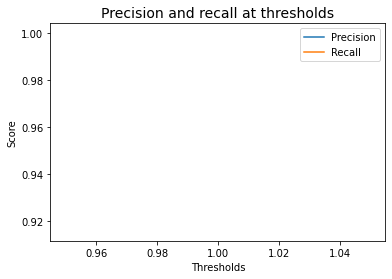

In [55]:
precision, recall, thresholds = precision_recall_curve(y_test, prediction)
# Using recall and precision at thresholds to find the middle ground for both
plt.plot(thresholds, precision[0:-1], label="Precision")
plt.plot(thresholds, recall[0:-1], label="Recall")
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.legend()
plt.title("Precision and recall at thresholds", fontsize=14)
plt.show()

## Large model

In [23]:
model = tf.keras.models.load_model("models/c03_n3_us_l5large_dropout/")
# Testing
test_loss, test_acc = model.evaluate(X_test, y_test)
prediction = model.predict(X_test)
evaluate_testing(y_test, prediction.round())

2282/2282 [==============================] - 6s 3ms/step
Confusion matrixes: 
[[    0  3861]
 [    0 69136]]


F1 score: 0.9728

Accuracy score: 0.9471

Recall score: 1.0


In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, prediction)

In [ ]:

# Using recall and precision at thresholds for optimal f2 scores
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

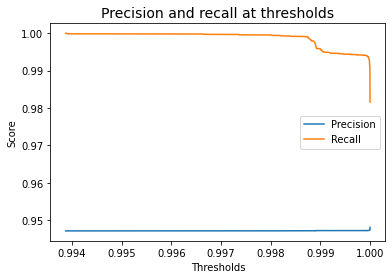

In [26]:
# Using recall and precision at thresholds to find the middle ground for both
plt.plot(thresholds, precision[0:-1], label="Precision")
plt.plot(thresholds, recall[0:-1], label="Recall")
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.legend()
plt.title("Precision and recall at thresholds", fontsize=14)
plt.show()

In [36]:
# Visualize data
alt_threshold_prediction = np.where(prediction > 0.99999, 1, 0)
evaluate_testing(y_test, alt_threshold_prediction)

Confusion matrixes: 
[[   45  3816]
 [  553 68583]]


F1 score: 0.9691

Accuracy score: 0.9401

Recall score: 0.992
